In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Convolution2D, MaxPool2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa 
import cv2
import matplotlib.image as mpimg
import pandas as pd
import ntpath
import random

In [2]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df = pd.read_csv("driving_log.csv", names = columns)
#pd.set_option("display.max_colwidth", -1)
df.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [3]:
def path_leaf(path):
    head, tail =ntpath.split(path)
    return tail

df['center']=df['center'].apply(path_leaf)
df['left']=df['left'].apply(path_leaf)
df['right']=df['right'].apply(path_leaf)
df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


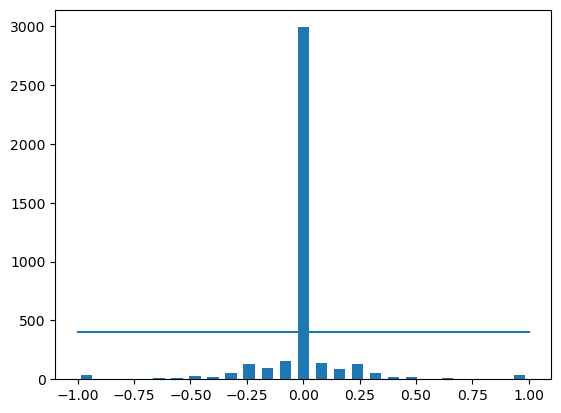

In [4]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['steering'], num_bins)
center = (bins[:-1]+ bins[1:])*0.5
print(center)
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))

total data: 4053
removed 2590
remaining: 1463


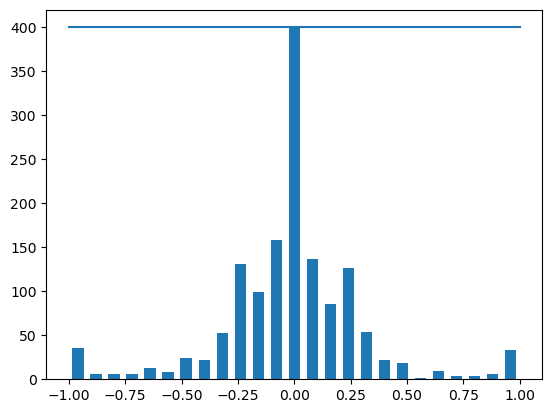

In [5]:
print("total data:", len(df))
remove_list = []
for j in range(num_bins):
    list_ =[]
    for i in range(len(df['steering'])):
        if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_= shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed', len(remove_list))
df.drop(df.index[remove_list], inplace=True)
print('remaining:', len(df))

hist, bins = np.histogram(df['steering'], num_bins)

plt.bar(center, hist, width= 0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))


In [6]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1,0.1), "y":(-0.1,0.1)})
    image = pan.augment_image(image)
    return image

def bright(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image       

def image_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() <0.5:
        image = pan(image)
    if np.random.rand() <0.5:
        image = zoom(image)
    if np.random.rand() <0.5:
        image = bright(image)
    if np.random.rand() <0.5:
        image,steering_angle = image_random_flip(image,steering_angle)
    return image, steering_angle



In [7]:
#print(df.iloc[1])
print(len(df))
def load_img_steering(df):
    image_path = []
    steering = []

    for i in range(len(df)):
        indexed_data = df.iloc[i]
        center, left,right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append( 'IMG/'+center.strip())
        steering.append(float(indexed_data[3]))
    return image_path, steering
    
image_paths, steerings = load_img_steering(df)
print(len(image_paths))

1463
1463


1170 293


Text(0.5, 1.0, 'Training set')

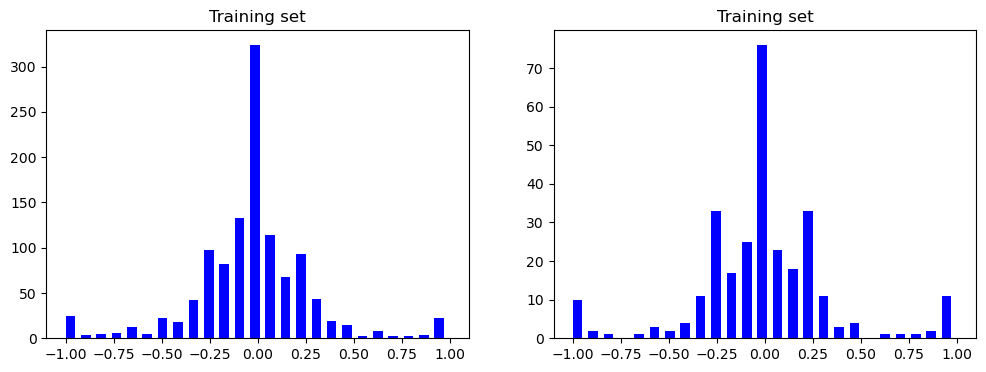

In [8]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.2, random_state=2)
print(len(X_train), len(X_test))

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axs[0].set_title('Training set')
axs[1].hist(y_test, bins=num_bins, width=0.05, color='blue')
axs[1].set_title('Training set')

Text(0.5, 1.0, 'zoomed')

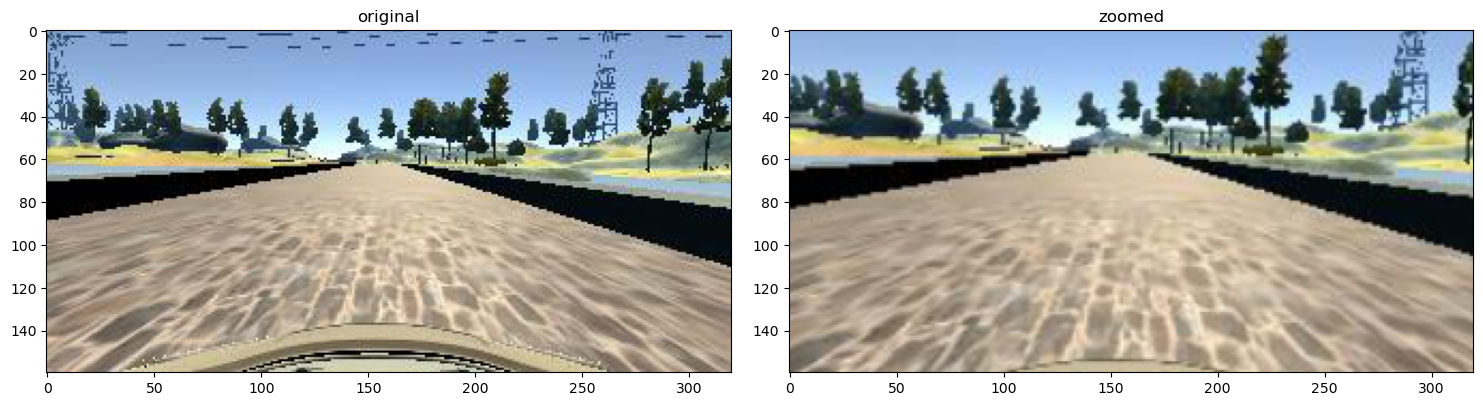

In [9]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs =plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("original")
axs[1].imshow(zoomed_image)
axs[1].set_title("zoomed")


In [10]:
def img_preprocess(img):
    img = img[60:135:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0 )
    img =  cv2.resize(img, (200, 66))
    img = img/255
    return img




Text(0.5, 1.0, 'proprocessed image')

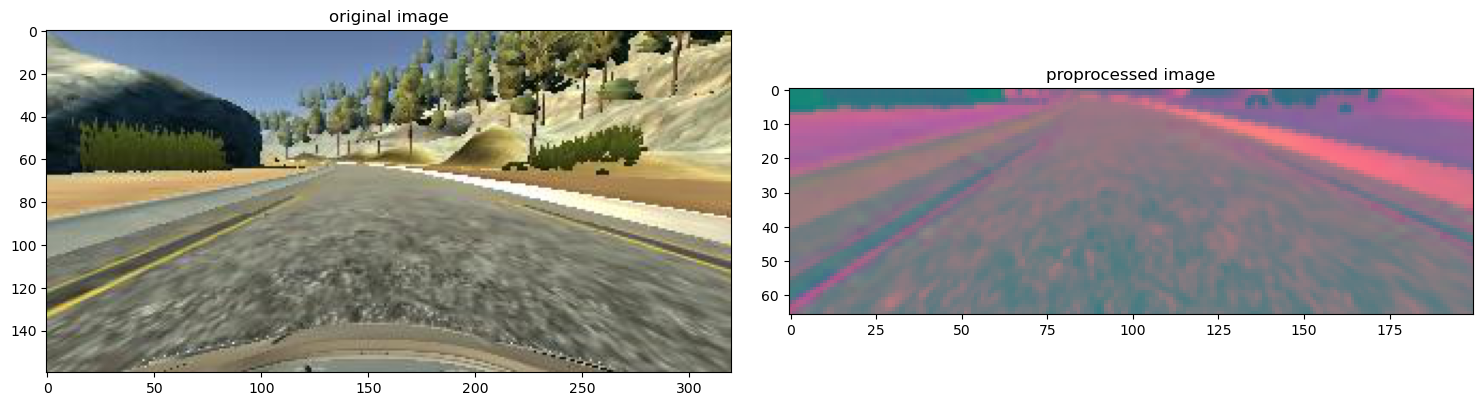

In [11]:
image = image_paths[150]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image')

axs[1].imshow(preprocessed_image)
axs[1].set_title('proprocessed image')




In [12]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
            yield (np.asarray(batch_img), np.asarray(batch_steering))  

In [13]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_test_gen, y_test_gen = next(batch_generator(X_test, y_test, 1, 0))

In [38]:
def nvidia_model():
 
    model = Sequential()
 
    model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
 
    model.add(Convolution2D(36, (5,5), strides=(2,2), activation='elu'))
    model.add(Convolution2D(48, (5,5), strides=(2,2), activation='elu'))
    model.add(Convolution2D(64, (3,3), activation='elu'))
    model.add(Convolution2D(64, (3,3), activation='elu'))
    # model.add(Dropout(0.5))
    
    
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    # model.add(Dropout(0.5))
    
    
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))
    
    
    optimizer= Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [40]:
model = nvidia_model()
print(model.summary)

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x000001EC89BADE90>>


In [45]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_test, y_test, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
  2/300 [..............................] - ETA: 18s - loss: 0.0191

C:\conda_temp\ipykernel_4240\625762174.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


300/300 [==============================] - 25s 83ms/step - loss: 0.0950 - val_loss: 0.0843
Epoch 2/10
300/300 [==============================] - 23s 75ms/step - loss: 0.0865 - val_loss: 0.1277
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 0.0894

Text(0.5, 0, 'Epoch')

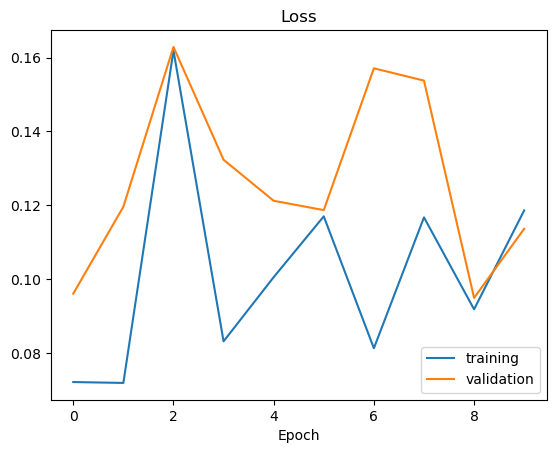

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [19]:
model.save('modle2.h5')